<a href="https://colab.research.google.com/github/caiogasparine/SCS_3253_061-Machine-Learning/blob/main/Toronto_Police_Major_Crime_Indicators_MCI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Source of Data: Major Crime Indicators (MCI) Historical**

This dataset includes all Major Crime Indicators (MCI) occurrences by reported date and related offences from 2014 to June 30, 2022.

https://data.torontopolice.on.ca/pages/major-crime-indicators


# 1 - Big Picture / Frame the problem 
University of Toronto
SCS 3253-061 - Machine Learning // Instructor: Saeid Abolfazli

**Group Members:**
*   Caio Gasparine
*   Fabio Queiroz
*   Olivier Sangam
*   Illidan Yuan

Created on February 18, 2023 / Last update on February 24, 2023

# 2 - Get the data / Develop the pipeline

Data profiling was done to ensure data quality and integrity. Contents of each field were analyzed for any anomalies and Null values. None we found.

In [59]:
### Loading the main used libraries
from datetime import date
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
### Change the code here, depending on your dataset location
### data = pd.read_csv('Major_Crime_Indicators.csv', header=0)
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Major_Crime_Indicators.csv', header=0)

In [61]:
data.shape

(301233, 30)

In [62]:
data.columns

Index(['X', 'Y', 'Index_', 'event_unique_id', 'Division', 'occurrencedate',
       'reporteddate', 'location_type', 'premises_type', 'ucr_code', 'ucr_ext',
       'offence', 'reportedyear', 'reportedmonth', 'reportedday',
       'reporteddayofyear', 'reporteddayofweek', 'reportedhour',
       'occurrenceyear', 'occurrencemonth', 'occurrenceday',
       'occurrencedayofyear', 'occurrencedayofweek', 'occurrencehour',
       'mci_category', 'Hood_ID', 'Neighbourhood', 'Longitude', 'Latitude',
       'ObjectId'],
      dtype='object')

# 3 - Explore and visualize the data to gain insights


In [63]:
data.head(5)

,X,Y,Index_,event_unique_id,Division,occurrencedate,reporteddate,location_type,premises_type,ucr_code,...,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,mci_category,Hood_ID,Neighbourhood,Longitude,Latitude,ObjectId
0,-8.850398e+06,5.429359e+06,201,GO-20141273318,D31,2014/01/03 05:00:00+00,2014/01/03 05:00:00+00,"Apartment (Rooming House, Condo)",Apartment,1430,...,3.0,3.0,Friday,11,Assault,27,York University Heights,-79.504475,43.766371,1
1,-8.818405e+06,5.436836e+06,202,GO-20141274349,D42,2014/01/03 05:00:00+00,2014/01/03 05:00:00+00,"Single Home, House (Attach Garage, Cottage, Mo...",House,2120,...,3.0,3.0,Friday,14,Break and Enter,132,Malvern,-79.217083,43.814861,2
2,-8.853791e+06,5.402071e+06,203,GO-20141274052,D22,2014/01/03 05:00:00+00,2014/01/03 05:00:00+00,"Open Areas (Lakes, Parks, Rivers)",Outside,1430,...,3.0,3.0,Friday,13,Assault,19,Long Branch,-79.534957,43.589085,3
3,-8.832822e+06,5.419628e+06,204,GO-20141276966,D53,2014/01/03 05:00:00+00,2014/01/03 05:00:00+00,Other Commercial / Corporate Places (For Profi...,Commercial,2130,...,3.0,3.0,Friday,12,Theft Over,55,Thorncliffe Park,-79.346588,43.703212,4
4,-8.853452e+06,5.410706e+06,205,GO-20141274457,D22,2014/01/03 05:00:00+00,2014/01/03 05:00:00+00,Convenience Stores,Commercial,1610,...,3.0,3.0,Friday,14,Robbery,14,Islington-City Centre West,-79.531916,43.645247,5


In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301233 entries, 0 to 301232
Data columns (total 30 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   X                    301233 non-null  float64
 1   Y                    301233 non-null  float64
 2   Index_               301233 non-null  int64  
 3   event_unique_id      301233 non-null  object 
 4   Division             301233 non-null  object 
 5   occurrencedate       301233 non-null  object 
 6   reporteddate         301233 non-null  object 
 7   location_type        301233 non-null  object 
 8   premises_type        301233 non-null  object 
 9   ucr_code             301233 non-null  int64  
 10  ucr_ext              301233 non-null  int64  
 11  offence              301233 non-null  object 
 12  reportedyear         301233 non-null  int64  
 13  reportedmonth        301233 non-null  object 
 14  reportedday          301233 non-null  int64  
 15  reporteddayofyear

In [65]:
data['mci_category'].value_counts()

Assault            161833
Break and Enter     59440
Auto Theft          40794
Robbery             29230
Theft Over           9936
Name: mci_category, dtype: int64

In [66]:
data['location_type'].value_counts()

Apartment (Rooming House, Condo)                                          72061
Single Home, House (Attach Garage, Cottage, Mobile)                       54076
Streets, Roads, Highways (Bicycle Path, Private Road)                     47619
Other Commercial / Corporate Places (For Profit, Warehouse, Corp. Bldg    34774
Parking Lots (Apt., Commercial Or Non-Commercial)                         25322
Bar / Restaurant                                                          12031
Open Areas (Lakes, Parks, Rivers)                                          6278
Schools During Supervised Activity                                         4567
Convenience Stores                                                         3851
Ttc Subway Station                                                         3648
Commercial Dwelling Unit (Hotel, Motel, B & B, Short Term Rental)          3454
Private Property Structure (Pool, Shed, Detached Garage)                   2743
Hospital / Institutions / Medical Facili

In [67]:
data['ucr_code'].value_counts()

1430    110901
2120     59416
2135     40794
1420     34218
1610     29229
2130      7018
1460      5282
1480      3486
1450      3471
1410      2502
2132      2423
1457      1089
1461       559
2133       495
1455       180
1470       106
1462        23
1440        14
2125        13
2121        11
1475         2
1611         1
Name: ucr_code, dtype: int64

In [68]:
data['premises_type'].value_counts()

Outside        80079
Apartment      72061
Commercial     60860
House          54076
Other          17788
Transit         8603
Educational     7766
Name: premises_type, dtype: int64

In [69]:
data['offence'].value_counts()

Assault                           110528
B&E                                50182
Theft Of Motor Vehicle             40794
Assault With Weapon                27191
Robbery - Mugging                   8393
B&E W'Intent                        7311
Assault Bodily Harm                 7027
Theft Over                          5532
Assault Peace Officer               5174
Robbery - Other                     4857
Robbery With Weapon                 4798
Robbery - Business                  4343
Assault - Resist/ Prevent Seiz      3018
Aggravated Assault                  2483
Theft From Motor Vehicle Over       2423
Robbery - Swarming                  2289
Discharge Firearm With Intent       2003
Unlawfully In Dwelling-House        1821
Discharge Firearm - Recklessly      1441
Theft From Mail / Bag / Key         1197
Robbery - Home Invasion             1132
Pointing A Firearm                  1089
Robbery - Purse Snatch              1039
Robbery - Financial Institute        891
Robbery - Vehicl

In [70]:
data['Neighbourhood'].value_counts()

Waterfront Communities-The Island    11302
Church-Yonge Corridor                 9942
Bay Street Corridor                   8530
West Humber-Clairville                8103
Moss Park                             7287
                                     ...  
Yonge-St.Clair                         596
Guildwood                              559
Maple Leaf                             550
Woodbine-Lumsden                       549
Lambton Baby Point                     472
Name: Neighbourhood, Length: 141, dtype: int64

In [71]:
data.describe()

,X,Y,Index_,ucr_code,ucr_ext,reportedyear,reportedday,reporteddayofyear,reportedhour,occurrenceyear,occurrenceday,occurrencedayofyear,occurrencehour,Longitude,Latitude,ObjectId
count,3.012330e+05,3.012330e+05,301233.000000,301233.000000,301233.000000,301233.000000,301233.000000,301233.000000,301233.000000,301133.000000,301133.000000,301133.000000,301233.000000,301233.000000,301233.000000,301233.000000
mean,-8.724562e+06,5.350375e+06,150617.000000,1702.422928,146.565585,2017.876713,15.736659,180.765756,12.808786,2017.822852,15.456476,180.544766,12.601591,-78.374071,43.143874,150617.000000
std,9.966746e+05,6.112283e+05,86958.621157,326.260102,51.988967,2.436940,8.766766,103.717225,6.502562,2.475716,8.914754,104.141362,7.243753,8.953280,4.928613,86958.621157
min,-8.910331e+06,0.000000e+00,1.000000,1410.000000,100.000000,2014.000000,1.000000,1.000000,0.000000,2000.000000,1.000000,1.000000,0.000000,-80.042866,0.000000,1.000000
25%,-8.846681e+06,5.412946e+06,75309.000000,1430.000000,100.000000,2016.000000,8.000000,92.000000,8.000000,2016.000000,8.000000,92.000000,7.000000,-79.471086,43.659806,75309.000000
50%,-8.838015e+06,5.419000e+06,150617.000000,1450.000000,100.000000,2018.000000,16.000000,178.000000,13.000000,2018.000000,15.000000,178.000000,14.000000,-79.393238,43.699132,150617.000000
75%,-8.829868e+06,5.426986e+06,225925.000000,2120.000000,200.000000,2020.000000,23.000000,270.000000,18.000000,2020.000000,23.000000,270.000000,19.000000,-79.320056,43.750978,225925.000000
max,0.000000e+00,5.517228e+06,301233.000000,2135.000000,230.000000,2022.000000,31.000000,366.000000,23.000000,2022.000000,31.000000,366.000000,23.000000,0.000000,44.333691,301233.000000


In [72]:
# Check if any column has missing values ("False" = not missing - "True" = missing)
data.isnull().any()

X                      False
Y                      False
Index_                 False
event_unique_id        False
Division               False
occurrencedate         False
reporteddate           False
location_type          False
premises_type          False
ucr_code               False
ucr_ext                False
offence                False
reportedyear           False
reportedmonth          False
reportedday            False
reporteddayofyear      False
reporteddayofweek      False
reportedhour           False
occurrenceyear          True
occurrencemonth         True
occurrenceday           True
occurrencedayofyear     True
occurrencedayofweek     True
occurrencehour         False
mci_category           False
Hood_ID                False
Neighbourhood          False
Longitude              False
Latitude               False
ObjectId               False
dtype: bool

In [73]:
data[['mci_category','offence','ucr_ext']]

,mci_category,offence,ucr_ext
0,Assault,Assault,100
1,Break and Enter,B&E,200
2,Assault,Assault,100
3,Theft Over,Theft Over,210
4,Robbery,Robbery - Business,210
...,...,...,...
301228,Auto Theft,Theft Of Motor Vehicle,210
301229,Auto Theft,Theft Of Motor Vehicle,210
301230,Auto Theft,Theft Of Motor Vehicle,210
301231,Auto Theft,Theft Of Motor Vehicle,210


In [74]:
data["mci_category"].value_counts()

Assault            161833
Break and Enter     59440
Auto Theft          40794
Robbery             29230
Theft Over           9936
Name: mci_category, dtype: int64

In [75]:
data[0:-1].describe()

,X,Y,Index_,ucr_code,ucr_ext,reportedyear,reportedday,reporteddayofyear,reportedhour,occurrenceyear,occurrenceday,occurrencedayofyear,occurrencehour,Longitude,Latitude,ObjectId
count,3.012320e+05,3.012320e+05,301232.000000,301232.000000,301232.000000,301232.000000,301232.000000,301232.000000,301232.000000,301132.000000,301132.000000,301132.000000,301232.000000,301232.000000,301232.000000,301232.000000
mean,-8.724561e+06,5.350375e+06,150616.500385,1702.421492,146.565375,2017.876700,15.736615,180.765759,12.808775,2017.822838,15.456431,180.544768,12.601580,-78.374067,43.143872,150616.500000
std,9.966762e+05,6.112293e+05,86958.333148,326.259691,51.988924,2.436932,8.766748,103.717397,6.502571,2.475708,8.914734,104.141535,7.243762,8.953294,4.928621,86958.332482
min,-8.910331e+06,0.000000e+00,1.000000,1410.000000,100.000000,2014.000000,1.000000,1.000000,0.000000,2000.000000,1.000000,1.000000,0.000000,-80.042866,0.000000,1.000000
25%,-8.846681e+06,5.412946e+06,75308.750000,1430.000000,100.000000,2016.000000,8.000000,92.000000,8.000000,2016.000000,8.000000,92.000000,7.000000,-79.471086,43.659806,75308.750000
50%,-8.838015e+06,5.419000e+06,150616.500000,1450.000000,100.000000,2018.000000,16.000000,178.000000,13.000000,2018.000000,15.000000,178.000000,14.000000,-79.393238,43.699132,150616.500000
75%,-8.829868e+06,5.426986e+06,225924.250000,2120.000000,200.000000,2020.000000,23.000000,270.000000,18.000000,2020.000000,23.000000,270.000000,19.000000,-79.320056,43.750978,225924.250000
max,0.000000e+00,5.517228e+06,301233.000000,2135.000000,230.000000,2022.000000,31.000000,366.000000,23.000000,2022.000000,31.000000,366.000000,23.000000,0.000000,44.333691,301232.000000


In [76]:
### Exploring the data to gain insigths
### Using pandas crosstab // Feb 24, 2023
data_ct = pd.crosstab(data.mci_category, data.reportedyear, margins=True)
data_ct

reportedyear,2014,2015,2016,2017,2018,2019,2020,2021,2022,All
mci_category,,,,,,,,,,
Assault,16817,18083,18904,19296,19905,21083,18309,19371,10065,161833
Auto Theft,3634,3282,3354,3627,4822,5355,5769,6572,4379,40794
Break and Enter,7231,6941,6446,6934,7612,8550,6985,5749,2992,59440
Robbery,3786,3544,3776,4100,3750,3721,2856,2286,1411,29230
Theft Over,1006,1047,1052,1191,1260,1398,1227,1080,675,9936
All,32474,32897,33532,35148,37349,40107,35146,35058,19522,301233


Text(0.5, 1.0, 'MCI Type by Year')

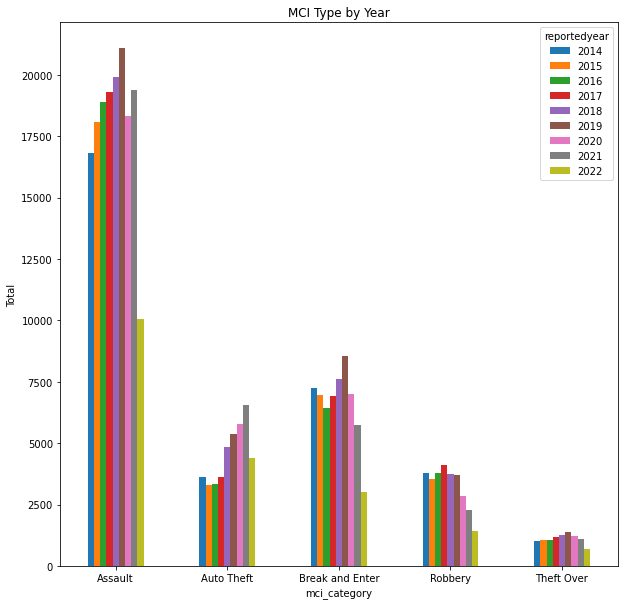

In [77]:
### Exploring the data to gain insigths
### Using pandas crosstab // Feb 24, 2023
data_ct_plot = pd.crosstab(data.mci_category, data.reportedyear)
data_ct_plot.plot(kind='bar', stacked=False, rot = 0, figsize=(10, 10));
plt.ylabel('Total')
plt.title('MCI Type by Year')

In [99]:
### Exploring the data to gain insigths
### Describe from data_crosstable // Feb 27,2023
data_ct[0:-1].describe()

reportedyear,2014,2015,2016,2017,2018,2019,2020,2021,2022,All
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,6494.800000,6579.400000,6706.400000,7029.600000,7469.800000,8021.400000,7029.200000,7011.600000,3904.400000,60246.600000
std,6179.370979,6766.785005,7082.501733,7154.075782,7315.459534,7751.731568,6706.434761,7281.094513,3730.173562,59565.167806
min,1006.000000,1047.000000,1052.000000,1191.000000,1260.000000,1398.000000,1227.000000,1080.000000,675.000000,9936.000000
25%,3634.000000,3282.000000,3354.000000,3627.000000,3750.000000,3721.000000,2856.000000,2286.000000,1411.000000,29230.000000
50%,3786.000000,3544.000000,3776.000000,4100.000000,4822.000000,5355.000000,5769.000000,5749.000000,2992.000000,40794.000000
75%,7231.000000,6941.000000,6446.000000,6934.000000,7612.000000,8550.000000,6985.000000,6572.000000,4379.000000,59440.000000
max,16817.000000,18083.000000,18904.000000,19296.000000,19905.000000,21083.000000,18309.000000,19371.000000,10065.000000,161833.000000


In [100]:
### Exploring the data to gain insigths
### Kurtosis from data_crosstable // Feb 27,2023
### Is a measure of the "tailedness" of the probability distribution of a real-valued random variable. Like skewness, kurtosis describes a particular aspect of a probability distribution. There are different ways to quantify kurtosis for a theoretical distribution, and there are corresponding ways of estimating it using a sample from a population. Different measures of kurtosis may have different interpretations.
### https://en.wikipedia.org/wiki/Kurtosis

data_ct[0:-1].kurtosis()

reportedyear
2014    2.614391
2015    3.119979
2016    3.603861
2017    3.457149
2018    3.190526
2019    2.878468
2020    2.892755
2021    3.151491
2022    2.256651
All     3.317356
dtype: float64

In [78]:
### Exploring the data to gain insigths
### Latitue and Longitude int(values) => 43 / -79 // a couple of ZEROS
data[['Latitude','Longitude']]

,Latitude,Longitude
0,43.766371,-79.504475
1,43.814861,-79.217083
2,43.589085,-79.534957
3,43.703212,-79.346588
4,43.645247,-79.531916
...,...,...
301228,43.790363,-79.455098
301229,43.775740,-79.234954
301230,43.765801,-79.281037
301231,0.000000,0.000000


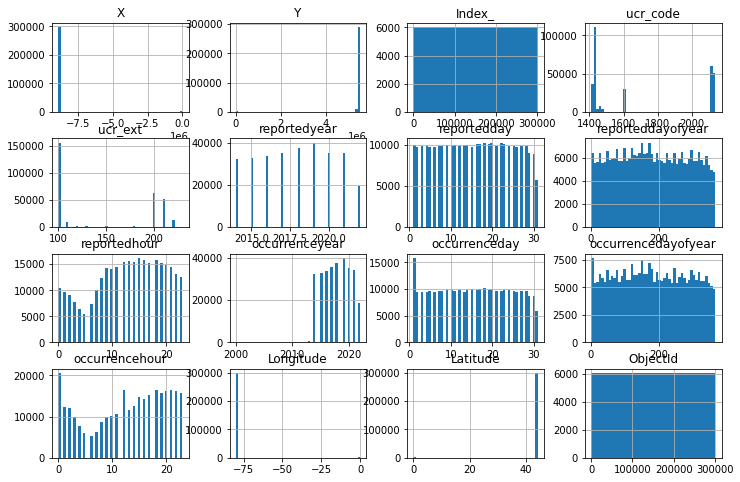

In [79]:
### Exploring the data to gain insigths
### Histogram for each numerical atribute
import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(12,8))
plt.show()

reportedyear
2014    16817
2015    18083
2016    18904
2017    19296
2018    19905
2019    21083
2020    18309
2021    19371
2022    10065
Name: Assault, dtype: int64


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



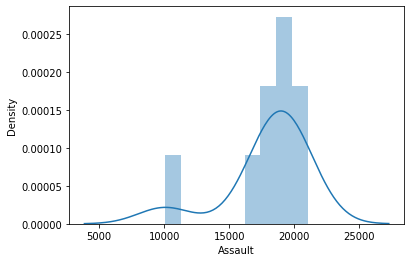

reportedyear
2014    3634
2015    3282
2016    3354
2017    3627
2018    4822
2019    5355
2020    5769
2021    6572
2022    4379
Name: Auto Theft, dtype: int64


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



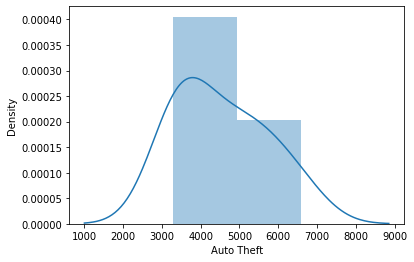

reportedyear
2014    7231
2015    6941
2016    6446
2017    6934
2018    7612
2019    8550
2020    6985
2021    5749
2022    2992
Name: Break and Enter, dtype: int64


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



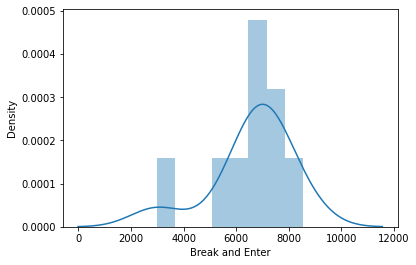

reportedyear
2014    3786
2015    3544
2016    3776
2017    4100
2018    3750
2019    3721
2020    2856
2021    2286
2022    1411
Name: Robbery, dtype: int64


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



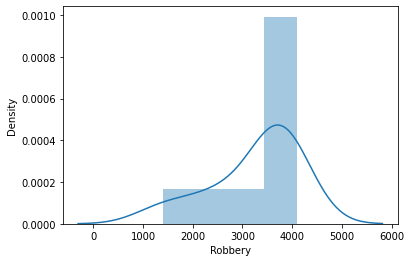

reportedyear
2014    1006
2015    1047
2016    1052
2017    1191
2018    1260
2019    1398
2020    1227
2021    1080
2022     675
Name: Theft Over, dtype: int64


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



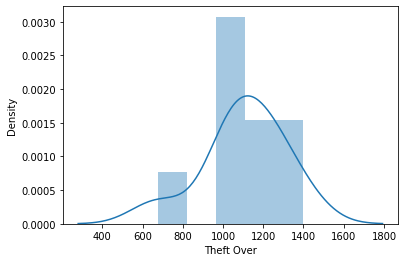

reportedyear
2014    32474
2015    32897
2016    33532
2017    35148
2018    37349
2019    40107
2020    35146
2021    35058
2022    19522
Name: All, dtype: int64


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



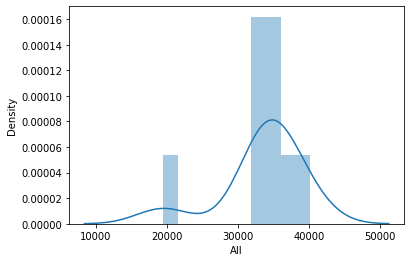

In [102]:
### Exploring the data to gain insigths
### Kurtosis from data_crosstable // Feb 27,2023
for i in range(0, data_ct.shape[0]):
    print (data_ct.iloc[i, 0:-1])
    sns.distplot(data_ct.iloc[i, 0:-1])
    #data_ct.iloc[i, 0:-1].hist(bins=5)
    plt.show()

## 3.1 MCI Category

In [80]:
### Exploring the data to gain insigths // MCI CATEGORY
### Trying to find data correlation / crosstab // Feb 24, 2023
data_ct_t =  pd.crosstab(data.mci_category, data.reportedyear, margins=False).reindex()
data_ct_t = data_ct_t.T
type_corr = data_ct_t.corr()
type_corr

mci_category,Assault,Auto Theft,Break and Enter,Robbery,Theft Over
mci_category,,,,,
Assault,1.000000,0.206109,0.880884,0.726337,0.915871
Auto Theft,0.206109,1.000000,0.005249,-0.464288,0.311310
Break and Enter,0.880884,0.005249,1.000000,0.847516,0.905835
Robbery,0.726337,-0.464288,0.847516,1.000000,0.659771
Theft Over,0.915871,0.311310,0.905835,0.659771,1.000000


(5.5, -0.5)

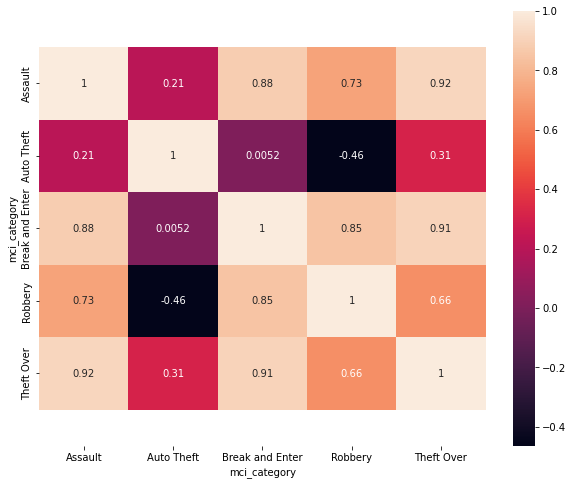

In [81]:
### Exploring the data to gain insigths
### Trying to find data correlation using sns seaborn // Feb 24, 2023
plt.figure(figsize=(10,8))
ax = sns.heatmap(type_corr, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

Correlations:

1.   **Assault** has high correlation with **Theft Over** and **Break and Enter**
2. **Auto Theft** has high correlation with **NONE**
3. **Break and Enter** has correlation with **Roberry** and **Theft Over** 
4. **Robbery** has high correlation with **Break and Enter** and **Assault**
5. **Theft Over** has high correlation with **Assault** and **Break and Enter**

In [82]:
### Exploring the data to gain insigths
### Trying to find data correlation using sns seaborn // Feb 24, 2023

## 3.2 Latitute and Longitude 

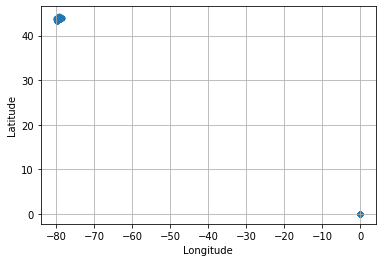

In [83]:
### Exploring the data to gain insigths
### Visualizing Goegraphical Data

import matplotlib.pyplot as plt
data.plot(kind="scatter", x="Longitude", y="Latitude", grid=True)
plt.show()

In [84]:
### Exploring the data to gain insigths
### Looking for correlations

corr_matrix = data.corr()
corr_matrix ["ucr_code"].sort_values(ascending=False)

ucr_code               1.000000
ucr_ext                0.920490
occurrenceyear         0.043597
Index_                 0.035648
ObjectId               0.035639
reportedyear           0.034324
Y                      0.025611
Latitude               0.025505
occurrenceday          0.011813
occurrencedayofyear    0.008028
reporteddayofyear      0.002388
reportedday           -0.000665
Longitude             -0.025991
X                     -0.025991
occurrencehour        -0.041091
reportedhour          -0.077251
Name: ucr_code, dtype: float64

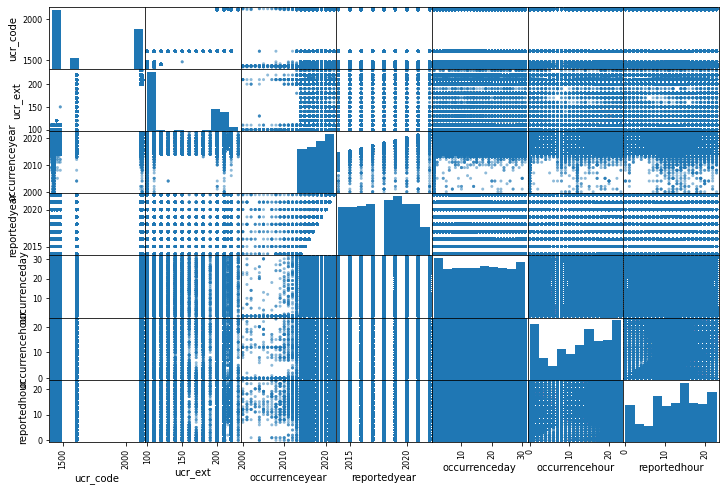

In [85]:
### Exploring the data to gain insigths
### Looking for correlations - using pandas Scatter Matrix
### Scatter Matrix plots every numerical atribute against every other attribite, plus a histogram of each numerical atribute's value on the main diagonal top left to bottom rigth 

from pandas.plotting import scatter_matrix
attributes = ["ucr_code", "ucr_ext", "occurrenceyear", "reportedyear", "occurrenceday", "occurrencehour", "reportedhour"]
scatter_matrix(data[attributes], figsize=(12,8))
plt.show()

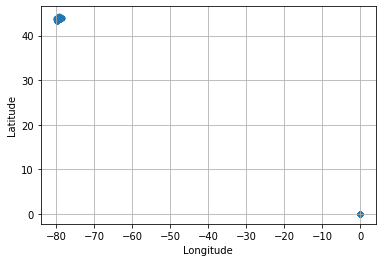

In [86]:
### Exploring the data to gain insigths
### Experiments - Attribute combinations (66)

import matplotlib.pyplot as plt
data.plot(kind="scatter", x="Longitude", y="Latitude", grid=True)
plt.show()

In [87]:
### Clean the data (68)
### Get rid of the instance / Get rid of the whole attribute / Set the missing values to some value (zero, median, mean, etc.)
### Panda's dataframe > dropna(), drop(), fillna() + Scikit-Learn SimpleImputer
### Solving the issue with Latitude and Longitude - ZERO VALUES

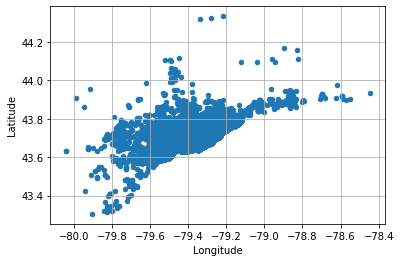

In [88]:
### Replace ZERO values for NaN = "Not a Number"
###data.replace(0, np.nan, inplace=True) ### To replace all the columns

cols = ["Latitude","Longitude"]
data[cols] = data[cols].replace(['0', 0], np.nan)

import matplotlib.pyplot as plt
data.plot(kind="scatter", x="Longitude", y="Latitude", grid=True)
plt.show()

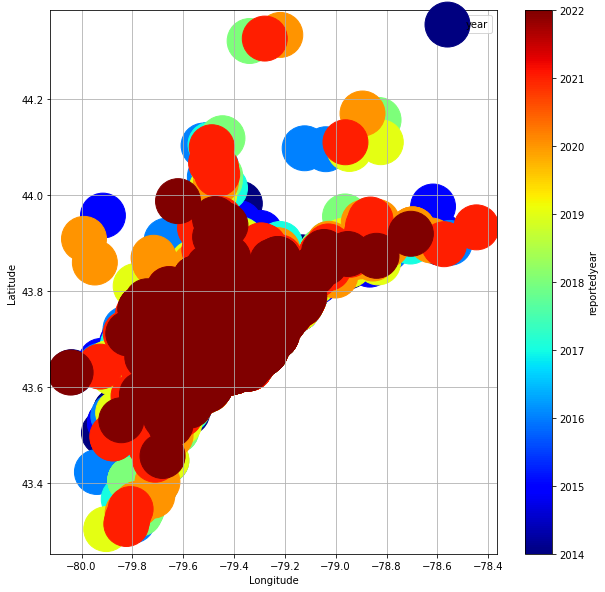

In [89]:
### Exploring the data to gain insigths
### Ploting Latitude + Longitude to visualize the data
###
import matplotlib.pyplot as plt
data.plot(kind="scatter", x="Longitude", y="Latitude", grid=True, 
          s=data["reportedyear"], label = "year",
          c="reportedyear", cmap="jet", colorbar=True, 
          legend=True, sharex=False, figsize=(10,10))
plt.show()

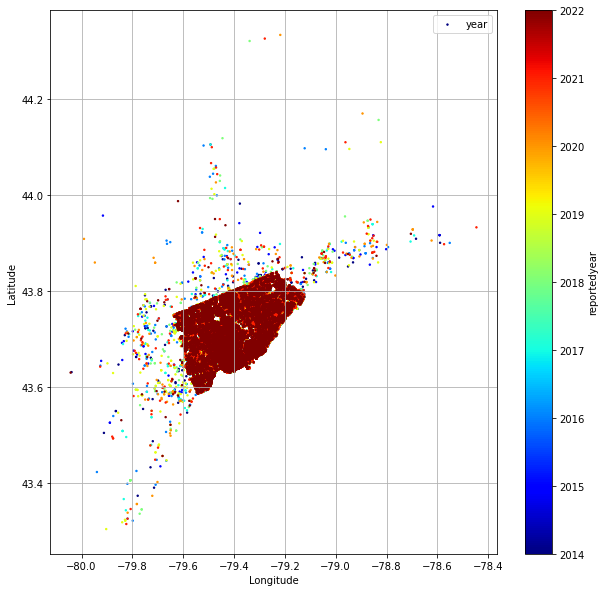

In [90]:
### Exploring the data to gain insigths
### Ploting Latitude + Longitude to visualize the data
###

import matplotlib.pyplot as plt
data.plot(kind="scatter", x="Longitude", y="Latitude", grid=True, 
          s=2, label = "year",
          c="reportedyear", cmap="jet", colorbar=True, 
          legend=True, sharex=False, figsize=(10,10))
plt.show()

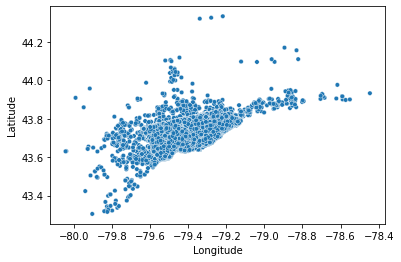

In [91]:
### Exploring the data to gain insigths
### Ploting Latitude + Longitude to visualize the data
###
import matplotlib.pyplot as plt
import seaborn as sns

graph = data.loc[data.Neighbourhood == 2015]
sns.scatterplot(data=data, x="Longitude", y="Latitude", size=1, legend=False, sizes=(20, 2000))
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.8/dist-packages/seaborn/matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


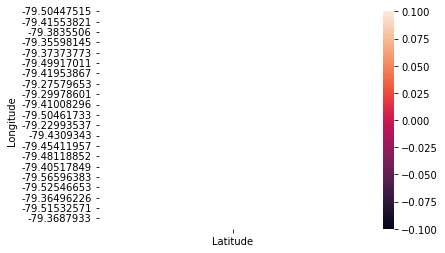

In [92]:
### Exploring the data to gain insigths
### Ploting Latitude + Longitude to visualize the data
###
import seaborn as sns
import pandas as pd
import numpy as np
graph2 = pd.DataFrame(data['Latitude'], data['Longitude'])
p1 = sns.heatmap(graph2)

In [93]:
### Exploring the data to gain insigths
### Ploting Latitude + Longitude to visualize the data
###

import plotly.express as px
import xarray as xr
# Load xarray from dataset included in the xarray tutorial
airtemps = xr.tutorial.open_dataset('air_temperature').air.sel(lon=250.0)
fig = px.imshow(airtemps.T, color_continuous_scale='RdBu_r', origin='lower')
fig.show()

In [94]:
### Adding a new attribute qtd of days since reported first time - using current date
### date.today() / datetime.now()
### time.struct_time((d.year, d.month, d.day, 0, 0, 0, d.weekday(), yday, -1))
### https://docs.python.org/3/library/datetime.html
### class datetime.datetime(year, month, day, hour=0, minute=0, second=0, microsecond=0, tzinfo=None, *, fold=0)

from datetime import date
from datetime import datetime
today_date_iso = (datetime.today())
data['reporteddate'] = pd.to_datetime(data['reporteddate'])
#data['days_since_reported'] = today_date_iso - datetime(data['reporteddate'], tzinfo=None).isoformat() 

#(pd.to_datetime(data['reporteddate']))
#data['reporteddate'] = datetime(data['reporteddate']).isoformat()
#data["days_since_reported"] = (datetime(2023, 2, 23, tzinfo=None).isoformat()) - (datetime(data['reporteddate'], tzinfo=None).isoformat())

#today = today.replace(tzinfo=None)


In [95]:
today_date_iso
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301233 entries, 0 to 301232
Data columns (total 30 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   X                    301233 non-null  float64            
 1   Y                    301233 non-null  float64            
 2   Index_               301233 non-null  int64              
 3   event_unique_id      301233 non-null  object             
 4   Division             301233 non-null  object             
 5   occurrencedate       301233 non-null  object             
 6   reporteddate         301233 non-null  datetime64[ns, UTC]
 7   location_type        301233 non-null  object             
 8   premises_type        301233 non-null  object             
 9   ucr_code             301233 non-null  int64              
 10  ucr_ext              301233 non-null  int64              
 11  offence              301233 non-null  object             
 12  re

,X,Y,Index_,event_unique_id,Division,occurrencedate,reporteddate,location_type,premises_type,ucr_code,...,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,mci_category,Hood_ID,Neighbourhood,Longitude,Latitude,ObjectId
0,-8.850398e+06,5.429359e+06,201,GO-20141273318,D31,2014/01/03 05:00:00+00,2014-01-03 05:00:00+00:00,"Apartment (Rooming House, Condo)",Apartment,1430,...,3.0,3.0,Friday,11,Assault,27,York University Heights,-79.504475,43.766371,1
1,-8.818405e+06,5.436836e+06,202,GO-20141274349,D42,2014/01/03 05:00:00+00,2014-01-03 05:00:00+00:00,"Single Home, House (Attach Garage, Cottage, Mo...",House,2120,...,3.0,3.0,Friday,14,Break and Enter,132,Malvern,-79.217083,43.814861,2
2,-8.853791e+06,5.402071e+06,203,GO-20141274052,D22,2014/01/03 05:00:00+00,2014-01-03 05:00:00+00:00,"Open Areas (Lakes, Parks, Rivers)",Outside,1430,...,3.0,3.0,Friday,13,Assault,19,Long Branch,-79.534957,43.589085,3
3,-8.832822e+06,5.419628e+06,204,GO-20141276966,D53,2014/01/03 05:00:00+00,2014-01-03 05:00:00+00:00,Other Commercial / Corporate Places (For Profi...,Commercial,2130,...,3.0,3.0,Friday,12,Theft Over,55,Thorncliffe Park,-79.346588,43.703212,4
4,-8.853452e+06,5.410706e+06,205,GO-20141274457,D22,2014/01/03 05:00:00+00,2014-01-03 05:00:00+00:00,Convenience Stores,Commercial,1610,...,3.0,3.0,Friday,14,Robbery,14,Islington-City Centre West,-79.531916,43.645247,5


In [96]:
dia = datetime.now(tz=None).isoformat()
dia

'2023-02-28T02:57:22.054891'

In [97]:
print (datetime(2023, 2, 23, tzinfo=None).isoformat())
#current date format -> 2014/01/03 05:00:00+00

2023-02-23T00:00:00


# 4 - Prepare the data for ML algorithm


# 5 - Select a Model and Train it

6 - Fine-tuning the model 

# 6 - Fine-tunig the model

# Results and Model Performance 